In [92]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

import shap

import numpy as np
import matplotlib.pyplot as plt

In [132]:
# Datensätze laden
df_analysis = pd.read_csv('df_camping_analysis.csv', encoding='utf-8')
df_analysis_cor = pd.read_csv('df_camping_analysis_no_cor.csv', encoding='utf-8')
df_analysis_outl = pd.read_csv('df_camping_analysis_no_outl.csv', encoding='utf-8')

In [133]:
# Random Forest - Modell mit Train-Test Split
def radom_forest_metrics(model, df):
    X = df.drop(columns=['Preis'])
    y = df['Preis']

    # Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modell trainieren
    model.fit(X_train, y_train)

    # Vorhersagen
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metriken berechnen
    metrics = {
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'test_mse': mean_squared_error(y_test, y_test_pred)
    }

    # Cross-Validation-Metriken hinzufügen
    cross_val_results = cross_val_metrics(model, X, y)
    metrics.update(cross_val_results)

    # Ausgeben von Metriken, Feature Importance Parameter
    return metrics, X_test, y_test, y_test_pred, model.feature_importances_

# Random Forest - Modell mit Cross-Validation
def cross_val_metrics(model, X, y):
    r2_scores = cross_val_score(model, X, y, cv=6, scoring='r2')
    mse_scores = cross_val_score(model, X, y, cv=6, scoring='neg_mean_squared_error')
    return {
        'cross_val_r2_mean': r2_scores.mean(),
        'cross_val_r2_std': r2_scores.std(),
        'cross_val_mse_mean': -mse_scores.mean(),
        'cross_val_mse_std': mse_scores.std()
    }


# Modell definieren
model = RandomForestRegressor(random_state=42)

# Metriken für beide Datensätze berechnen
metrics_df_analysis, X_test_analysis, y_test_analysis, y_test_pred_analysis, feature_importances_analysis = radom_forest_metrics(model, df_analysis)
metrics_df_analysis_cor, X_test_cor, y_test_cor, y_test_pred_cor, feature_importances_cor = radom_forest_metrics(model, df_analysis_cor)
metrics_df_analysis_outl, X_test_outl, y_test_outl, y_test_pred_outl, feature_importances_outl = radom_forest_metrics(model, df_analysis_outl)

# Zusammenführen der Ergebnisse in einem DataFrame und ausgeben
results = pd.DataFrame([metrics_df_analysis, metrics_df_analysis_cor, metrics_df_analysis_outl], index=['df_analysis', 'df_analysis_cor', 'df_analysis_outl'])

results

,train_r2,test_r2,train_mse,test_mse,cross_val_r2_mean,cross_val_r2_std,cross_val_mse_mean,cross_val_mse_std
df_analysis,0.953216,0.628582,10.565698,54.006189,0.409884,0.101964,118.646829,70.869062
df_analysis_cor,0.952829,0.527576,10.653145,68.692931,0.415976,0.107446,117.966238,73.190753
df_analysis_outl,0.947014,0.549389,6.437347,62.373496,0.408518,0.150222,68.870921,15.882624


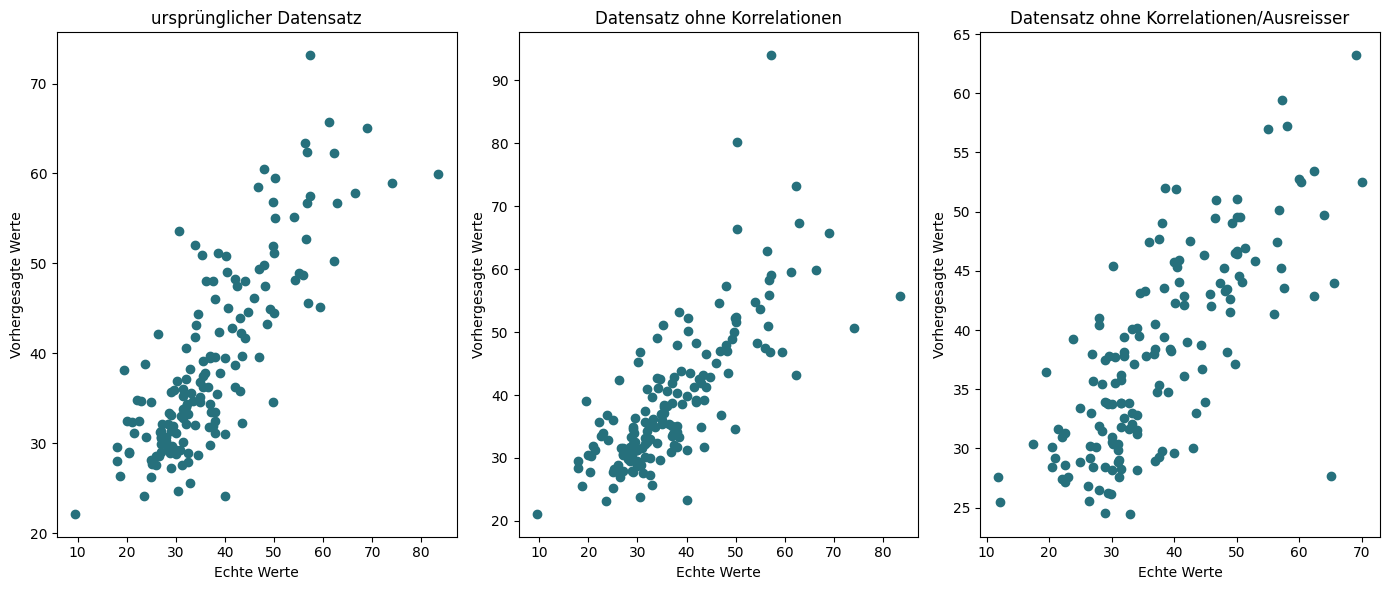

In [134]:
# Streudiagramme erstellen
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.scatter(y_test_analysis, y_test_pred_analysis, c='#26707C')
plt.xlabel('Echte Werte')
plt.ylabel('Vorhergesagte Werte')
plt.title('ursprünglicher Datensatz')

plt.subplot(1, 3, 2)
plt.scatter(y_test_cor, y_test_pred_cor,c='#26707C')
plt.xlabel('Echte Werte')
plt.ylabel('Vorhergesagte Werte')
plt.title('Datensatz ohne Korrelationen')

plt.subplot(1, 3, 3)
plt.scatter(y_test_outl, y_test_pred_outl,c='#26707C')
plt.xlabel('Echte Werte')
plt.ylabel('Vorhergesagte Werte')
plt.title('Datensatz ohne Korrelationen/Ausreisser')

plt.tight_layout()
plt.show()

# Hyperparameter-Tuning

Beim Hyperparameter-Tuning mit Grid Search (oder anderen Methoden wie Random Search) verwendet man in der Regel keine explizite Train-Test-Split vor der Grid Search. Stattdessen übernimmt die Cross-Validation innerhalb der Grid Search diese Aufgabe.

In [124]:
# Hyperparameter-Tuning für Random Forest
def tune_random_forest(X, y):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    rf = RandomForestRegressor(random_state=42)
    rf_cv = GridSearchCV(estimator=rf, param_grid=param_grid, cv=6, n_jobs=-1, verbose=2)
    rf_cv.fit(X, y)

    return rf_cv.best_estimator_, rf_cv.best_params_

# Daten vorbereiten
X = df_analysis_outl.drop(columns=['Preis'])
y = df_analysis_outl['Preis']

# Hyperparameter-Tuning durchführen
best_rf_model, best_rf_params = tune_random_forest(X, y)

# Modell mit den besten Parametern trainieren und Metriken berechnen
metrics_rf, X_test_rf, y_test_rf, y_test_pred_rf, best_rf_model,  = radom_forest_metrics(best_rf_model, df_analysis_outl)


# Ergebnisse anzeigen
print("Best parameters found: ", best_rf_params)
print(metrics_rf)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found:  {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
{'train_r2': 0.8970784049352779, 'test_r2': 0.61366574770414, 'train_mse': 23.243909943811, 'test_mse': 56.175022672379846, 'cross_val_r2_mean': 0.40268995206278524, 'cross_val_r2_std': 0.23033070779205256, 'cross_val_mse_mean': 118.99955619873035, 'cross_val_mse_std': 66.71315453217726}


# XAI

In [126]:
# Random Forest - Modell mit Train-Test Split
def radom_forest_metrics(model, df):
    X = df.drop(columns=['Preis'])
    y = df['Preis']

    # Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modell trainieren
    model.fit(X_train, y_train)

    # Vorhersagen
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metriken berechnen
    metrics = {
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'test_mse': mean_squared_error(y_test, y_test_pred)
    }

    # Cross-Validation-Metriken hinzufügen
    cross_val_results = cross_val_metrics(model, X, y)
    metrics.update(cross_val_results)

    # Ausgeben von Metriken, Feature Importance Parameter
    return metrics, X_test, y_test, y_test_pred, model.feature_importances_

# Random Forest - Modell mit Cross-Validation
def cross_val_metrics(model, X, y):
    r2_scores = cross_val_score(model, X, y, cv=6, scoring='r2')
    mse_scores = cross_val_score(model, X, y, cv=6, scoring='neg_mean_squared_error')
    return {
        'cross_val_r2_mean': r2_scores.mean(),
        'cross_val_r2_std': r2_scores.std(),
        'cross_val_mse_mean': -mse_scores.mean(),
        'cross_val_mse_std': mse_scores.std()
    }


# Modell definieren
model = RandomForestRegressor(random_state=42, bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100)

# Metriken für beide Datensätze berechnen
metrics_df_analysis_outl, X_test_outl, y_test_outl, y_test_pred_outl, feature_importances_outl = radom_forest_metrics(model, df_analysis_outl)

# Zusammenführen der Ergebnisse in einem DataFrame und ausgeben
results = pd.DataFrame([metrics_df_analysis_outl], index=['df_analysis_outl'])

results

,train_r2,test_r2,train_mse,test_mse,cross_val_r2_mean,cross_val_r2_std,cross_val_mse_mean,cross_val_mse_std
df_analysis_outl,0.881015,0.517963,14.45562,66.723488,0.411487,0.133346,68.767559,15.134502


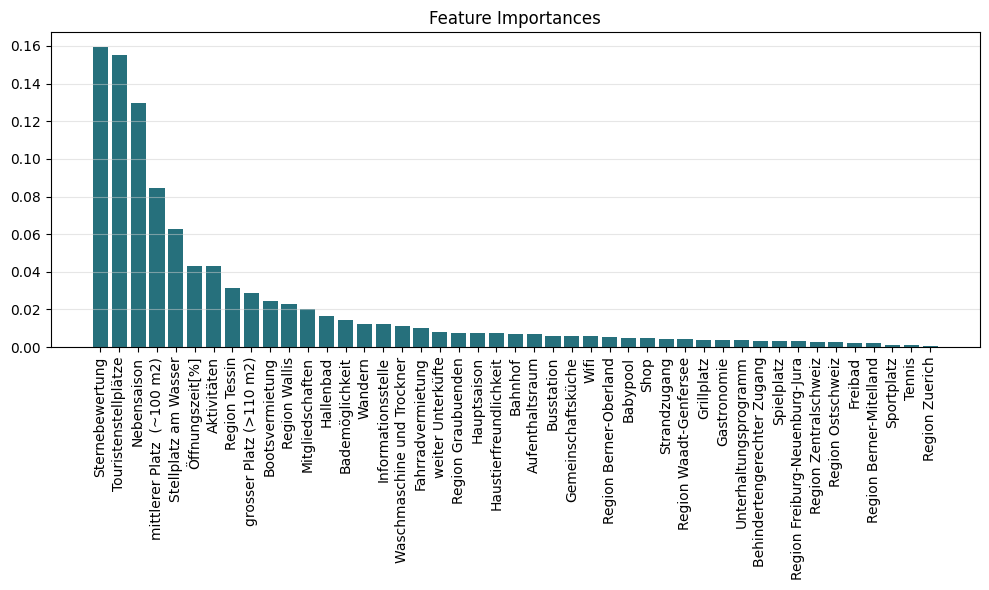

In [127]:
# Feature Importances anzeigen für den ursprünglichen Datensatz
features = df_analysis_outl.drop(columns=['Preis']).columns
sorted_indices_analysis = np.argsort(feature_importances_outl)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')

plt.bar(range(len(features)), feature_importances_outl[sorted_indices_analysis], align='center', color='#26707C')
plt.xticks(range(len(features)), [features[i] for i in sorted_indices_analysis], rotation=90)
plt.grid(axis='y', alpha=0.5, color='#CFCFCF')
plt.tight_layout()
plt.show()


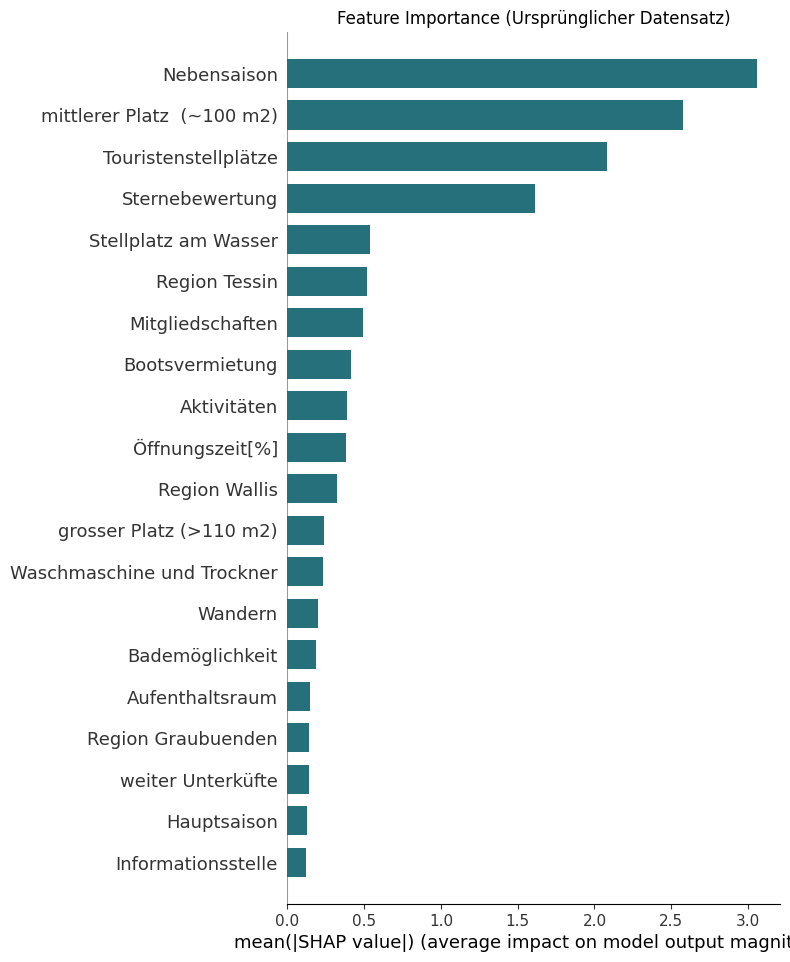

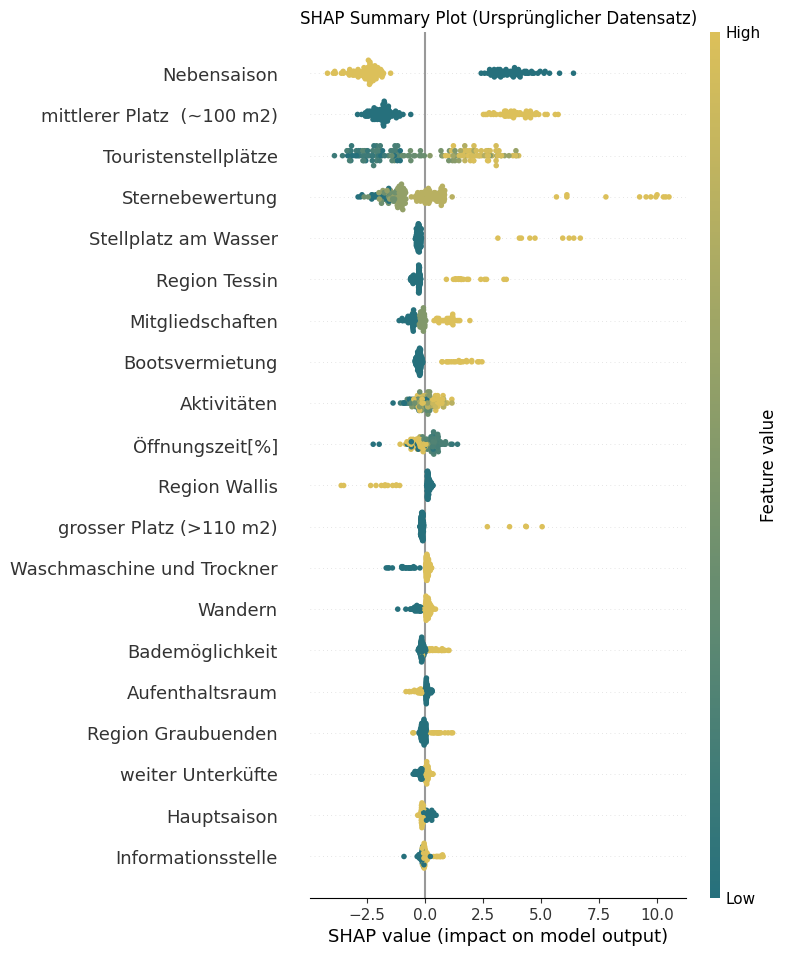

In [128]:
from matplotlib.colors import LinearSegmentedColormap

# SHAP-Analyse durchführen
explainer_analysis = shap.Explainer(model, X_test_outl)
shap_values_analysis = explainer_analysis(X_test_outl)

# SHAP-Werte visualisieren
shap.summary_plot(shap_values_analysis, X_test_outl, plot_type="bar", show=False, color='#26707C')
plt.title('Feature Importance (Ursprünglicher Datensatz)')
plt.show()

newCmap = LinearSegmentedColormap.from_list("", ['#26707C','#DCC05A'])
shap.summary_plot(shap_values_analysis, X_test_outl, show=False,cmap=newCmap)
plt.title('SHAP Summary Plot (Ursprünglicher Datensatz)')
plt.show()